# Exploratory Analysis Notebook

## 1. Introduction

To support Seattle’s ambition of becoming a carbon-neutral city by 2050, the city is focusing on reducing emissions from non-residential buildings—currently among the largest contributors to greenhouse gas emissions. While detailed energy audits were carried out in 2016, these surveys are costly and time-consuming. The goal of this project is to build predictive models that estimate CO₂ emissions and total energy consumption of buildings using their structural and contextual features (e.g., size, usage type, year built, location). The project also explores the usefulness of the ENERGY STAR Score, a performance indicator that’s laborious to calculate, to determine whether it improves prediction performance enough to justify the effort.

Problem statement: Can we accurately predict the CO₂ emissions and total energy consumption of non-residential buildings in Seattle using their structural characteristics and available data, and what is the added predictive value of including the ENERGY STAR Score?

This notebook covers Milestone 1 and 3:
* Perform exploratory data analysis (EDA).
* Clean the data.
* Perform feature engineering.

## 2. Environment Setup and Library Imports

In [3]:
# Libraries
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from spicy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import zscore

# Set-up environment
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_colwidth', None)
sns.set_theme(style="whitegrid", context="paper")
os.chdir('/Users/nataschajademinnitt/Documents/5. Data Analysis/open_classrooms/project_4')
print("Current directory:", os.getcwd())

Current directory: /Users/nataschajademinnitt/Documents/5. Data Analysis/open_classrooms/project_4


## 3. Load Data

In [5]:
# Load the file
raw = pd.read_csv('./data/raw/2016_Building_Energy_Benchmarking.csv')
raw.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.00000,0659000030,...,1156514.25000,3946027.00000,12764.52930,1276453.00000,False,NaN,Compliant,NaN,249.98000,2.83000
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.00000,0659000220,...,950425.18750,3242851.00000,51450.81641,5145082.00000,False,NaN,Compliant,NaN,295.86000,2.86000
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.00000,0659000475,...,14515435.00000,49526664.00000,14938.00000,1493800.00000,False,NaN,Compliant,NaN,2089.28000,2.19000
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.00000,0659000640,...,811525.31250,2768924.00000,18112.13086,1811213.00000,False,NaN,Compliant,NaN,286.43000,4.67000
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.00000,0659000970,...,1573448.62500,5368607.00000,88039.98438,8803998.00000,False,NaN,Compliant,NaN,505.01000,2.88000


In [6]:
# Target columns
df_obj = raw.rename(columns={
    'SiteEnergyUseWN(kBtu)': 'energy_target',
    'TotalGHGEmissions': 'emissions_target'
}).copy()

## 4. Data Cleaning and Filtering

### 4.1. Filter the Dataset
* Keep only non-residential buildings (using criteria on 'BuildingType', 'PrimaryPropertyType', etc.).
* Remove non-compliant buildings and outliers (using columns like 'ComplianceStatus' and 'Outlier').

In [9]:
# Only keep non-residential buildings in 'BuildingType'
cols = ['NonResidential', 'SPS-District K-12', 'Nonresidential COS', 'Campus', 'Nonresidential WA']
df_obj = df_obj[df_obj['BuildingType'].isin(cols)]

# Only keep non-residential buildings in 'PrimaryPropertyType'
cols = ['Residence Hall', 'Low-Rise Multifamily', 'Senior Care Community']
df_obj = df_obj[~df_obj['PrimaryPropertyType'].isin(cols)]

# Only keep non-residential buildings in 'ListOfAllPropertyUseTypes'
df_obj = df_obj[~df_obj['ListOfAllPropertyUseTypes'].str.contains('multifamily', case=False, na=False)]

# Keep only compliant buildings
df_obj = df_obj[df_obj['ComplianceStatus'] == 'Compliant']

# Remove outliers
df_obj = df_obj[df_obj['Outlier'].isna()]

print(f'Number of rows remaining: {df_obj.shape[0]}')

Number of rows remaining: 1469


In this context, "multifamily" refers to residential buildings that contain multiple separate housing units—such as apartment complexes, condominiums, or similar structures.

### 4.2. Clean Categorical Features
* Handle missing values in categorical columns (e.g., filling in 'LargestPropertyUseType').
* Standardize values (e.g., convert Neighborhood names to uppercase).

In [12]:
# Consolidate Neighborhood names
df_obj['Neighborhood'] = df_obj['Neighborhood'].str.upper()
neighborhood_map = {'DELRIDGE NEIGHBORHOODS': 'DELRIDGE'}
df_obj['Neighborhood'] = df_obj['Neighborhood'].replace(neighborhood_map)

In [13]:
# Fill NaN values in 'LargestPropertyUseType' using 'ListOfAllPropertyUseTypes'
first_use = df_obj['ListOfAllPropertyUseTypes'].str.split('/').str[0]
df_obj['LargestPropertyUseType'] = df_obj['LargestPropertyUseType'].fillna(first_use)

### 4.3. Clean Numeric Features
* Address missing values, outliers, and consistency issues in numeric columns.
* Ensure that numeric relationships (e.g., PropertyGFATotal vs. PropertyGFABuilding(s)) are consistent.

In [15]:
# Replace or drop numeric NaN values for property type
df_num = df_obj.copy()

# Assume that LargestPropertyUseTypeGFA NaN == PropertyGFATotal
df_num['LargestPropertyUseTypeGFA'] = df_num['LargestPropertyUseTypeGFA'].fillna(df_num['PropertyGFATotal'])

# Assume that second and third largest property NaN = 0
df_num.loc[df_num['SecondLargestPropertyUseType'].isna(), 'SecondLargestPropertyUseTypeGFA'] = 0
df_num.loc[df_num['ThirdLargestPropertyUseType'].isna(), 'ThirdLargestPropertyUseTypeGFA'] = 0

# Remove rows with NaN target values
df_num = df_num.dropna(subset=['energy_target'])
df_num = df_num.dropna(subset=['emissions_target'])

In [16]:
# Ensuring that PropertyGFATotal is greater than PropertyGFABuilding(s)
check = df_num['PropertyGFATotal'] < df_num['PropertyGFABuilding(s)']
print("Number of rows where PropertyGFABuilding(s) > PropertyGFATotal:", check.sum())

Number of rows where PropertyGFABuilding(s) > PropertyGFATotal: 0


In [17]:
# Ensuring that PropertyGFATotal is greater than PropertyGFAParking
check = df_num['PropertyGFATotal'] < df_num['PropertyGFAParking']
print("Number of rows where PropertyGFAParking > PropertyGFATotal:", check.sum())

Number of rows where PropertyGFAParking > PropertyGFATotal: 0


In [18]:
# Ensuring that PropertyGFATotal is equal to PropertyGFABuilding(s) and PropertyGFAParking
check = df_num['PropertyGFATotal'] != df_num['PropertyGFAParking'] + df_num['PropertyGFABuilding(s)']
print("Number of rows where PropertyGFATotal != PropertyGFAParking + PropertyGFABuilding(s):", check.sum())
df_num = df_num[~check]

Number of rows where PropertyGFATotal != PropertyGFAParking + PropertyGFABuilding(s): 0


In [19]:
# Drop rows where SecondLargestPropertyUseTypeGFA > LargestPropertyUseTypeGFA
mask = df_num['SecondLargestPropertyUseTypeGFA'] > df_num['LargestPropertyUseTypeGFA']
print("Number of rows to drop where SecondLargestPropertyUseTypeGFA > LargestPropertyUseTypeGFA:", mask.sum())
df_num = df_num.loc[~mask].copy()

Number of rows to drop where SecondLargestPropertyUseTypeGFA > LargestPropertyUseTypeGFA: 0


In [20]:
# Floors highest than Seattle max (78)
check = df_num['NumberofFloors'] >= 78
print("Number of rows to drop where NumberofFloors > 78:", check.sum())
df_num = df_num[~check]

Number of rows to drop where NumberofFloors > 78: 1


In [21]:
# Removing negative values
numeric_cols = df_num.select_dtypes(include=[np.number]).columns
numeric_cols = numeric_cols.drop(['Latitude', 'Longitude'])
has_negative = (df_num[numeric_cols] < 0).any()
print(has_negative)

# Columns with negative
df_num = df_num[df_num['emissions_target'] >= 0]
df_num = df_num[df_num['Electricity(kBtu)'] >= 0]

OSEBuildingID                      False
DataYear                           False
ZipCode                            False
CouncilDistrictCode                False
YearBuilt                          False
NumberofBuildings                  False
NumberofFloors                     False
PropertyGFATotal                   False
PropertyGFAParking                 False
PropertyGFABuilding(s)             False
LargestPropertyUseTypeGFA          False
SecondLargestPropertyUseTypeGFA    False
ThirdLargestPropertyUseTypeGFA     False
ENERGYSTARScore                    False
SiteEUI(kBtu/sf)                   False
SiteEUIWN(kBtu/sf)                 False
SourceEUI(kBtu/sf)                 False
SourceEUIWN(kBtu/sf)                True
SiteEnergyUse(kBtu)                False
energy_target                      False
SteamUse(kBtu)                     False
Electricity(kWh)                    True
Electricity(kBtu)                   True
NaturalGas(therms)                 False
NaturalGas(kBtu)

In [22]:
# Check that longitude is (~ 122 W) and latitude is (~47 N)
df_num[['Latitude', 'Longitude']].describe()

,Latitude,Longitude
count,1466.00000,1466.00000
mean,47.61565,-122.33378
std,0.04727,0.02325
min,47.50959,-122.41182
25%,47.58594,-122.34292
50%,47.61230,-122.33322
75%,47.64778,-122.32315
max,47.73387,-122.26180


In [23]:
# Remaining missing values
missing = df_num.isna().mean() * 100
missing

OSEBuildingID                       0.00000
DataYear                            0.00000
BuildingType                        0.00000
PrimaryPropertyType                 0.00000
PropertyName                        0.00000
Address                             0.00000
City                                0.00000
State                               0.00000
ZipCode                             0.88677
TaxParcelIdentificationNumber       0.00000
CouncilDistrictCode                 0.00000
Neighborhood                        0.00000
Latitude                            0.00000
Longitude                           0.00000
YearBuilt                           0.00000
NumberofBuildings                   0.00000
NumberofFloors                      0.00000
PropertyGFATotal                    0.00000
PropertyGFAParking                  0.00000
PropertyGFABuilding(s)              0.00000
ListOfAllPropertyUseTypes           0.00000
LargestPropertyUseType              0.00000
LargestPropertyUseTypeGFA       

## 5. Exploratory Data Analysis

1. **Correlation Heatmap**

The heatmap shows very high correlations among building area variables, suggesting potential multicollinearity.

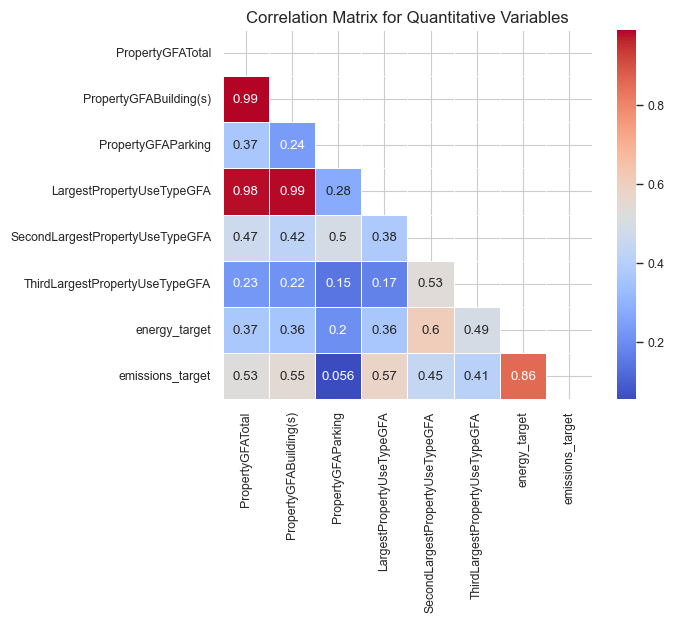

In [26]:
cols = [
        'PropertyGFATotal',          
        'PropertyGFABuilding(s)',
        'PropertyGFAParking',
        'LargestPropertyUseTypeGFA',
        'SecondLargestPropertyUseTypeGFA',
        'ThirdLargestPropertyUseTypeGFA',
        'energy_target',
        'emissions_target'
       ]

corr = df_num[cols].corr()

# Plot
mask = np.triu(corr)
sns.heatmap(corr, annot=True, cmap='coolwarm', mask=mask, linewidths=.5, cbar=True, square=True)
plt.title("Correlation Matrix for Quantitative Variables", fontsize=12)
plt.show()

2. **Building Height by Neighborhood**



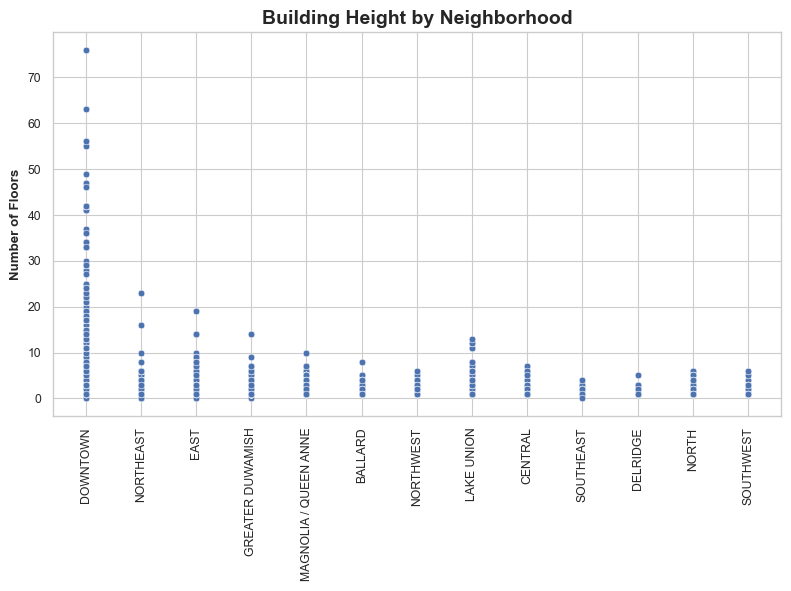

In [28]:
# Building height by neighborhood
plt.figure(figsize=(8,6))
sns.scatterplot(x='Neighborhood', y='NumberofFloors', data=df_num)
plt.xticks(rotation=90)
plt.title('Building Height by Neighborhood', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('Number of Floors', fontweight='bold')
plt.tight_layout()
plt.savefig(f"./results/figures/Building_Height_by_Neighborhood.png")
plt.show()

Observation: Building height appears to be coherent with neighborhood.

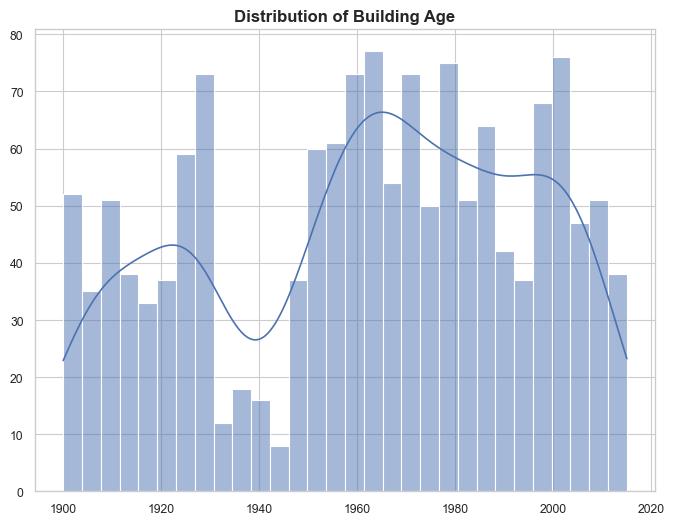

In [30]:
# Distribution of building age
plt.figure(figsize=(8,6))
sns.histplot(df_num['YearBuilt'], bins=30, kde=True)
plt.title('Distribution of Building Age', fontsize=12, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.savefig(f"./results/figures/Building_Age.png")
plt.show()

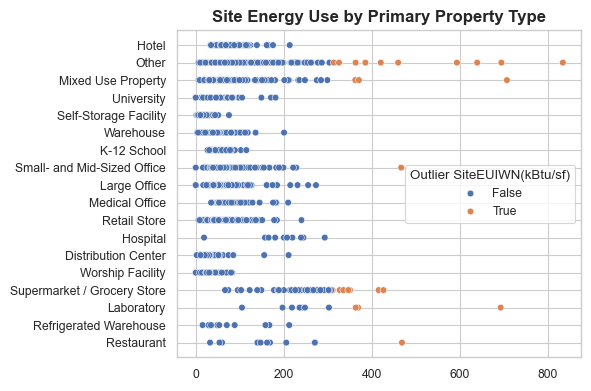

In [31]:
# Calculate z-scores for energy_target
df_num['zscore_energy_target'] = np.abs(stats.zscore(df_num['SiteEUIWN(kBtu/sf)']))

df_num['Outlier SiteEUIWN(kBtu/sf)'] = df_num['zscore_energy_target'] > 3

# Plot
plt.figure(figsize=(6,4))
sns.scatterplot(x='SiteEUIWN(kBtu/sf)', 
                y='PrimaryPropertyType', 
                hue='Outlier SiteEUIWN(kBtu/sf)', 
                data=df_num)
plt.title("Site Energy Use by Primary Property Type", fontsize=12, fontweight='bold')
plt.ylabel('')
plt.xlabel('')
plt.tight_layout()
plt.savefig(f"./results/figures/Site_Energy_Use_by_Primary_Property_Type.png")
plt.show()

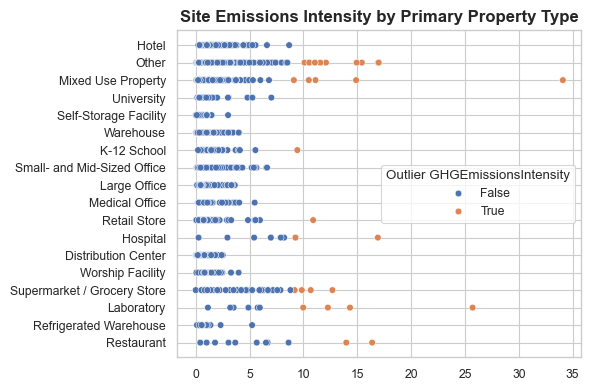

In [32]:
# Calculate z-scores for energy_target
df_num['zscore_emissions_target'] = np.abs(stats.zscore(df_num['GHGEmissionsIntensity']))

df_num['Outlier GHGEmissionsIntensity'] = df_num['zscore_emissions_target'] > 3

# Plot
plt.figure(figsize=(6,4))
sns.scatterplot(x='GHGEmissionsIntensity', 
                y='PrimaryPropertyType', 
                hue='Outlier GHGEmissionsIntensity', 
                data=df_num)
plt.title("Site Emissions Intensity by Primary Property Type", fontsize=12, fontweight='bold')
plt.ylabel('')
plt.xlabel('')
plt.tight_layout()
plt.savefig(f"./results/figures/Site_Emissions_Use_by_Primary_Property_Type.png")
plt.show()

## 6. Feature Engineering

### 6.1. Feature scaling

Log transformation was applied to selected features and the target to reduce skewness and the impact of extreme values, such as outliers with a Z-score greater than 3. This transformation helps compress large values and bring the distributions closer to normality, improving model stability without removing data.

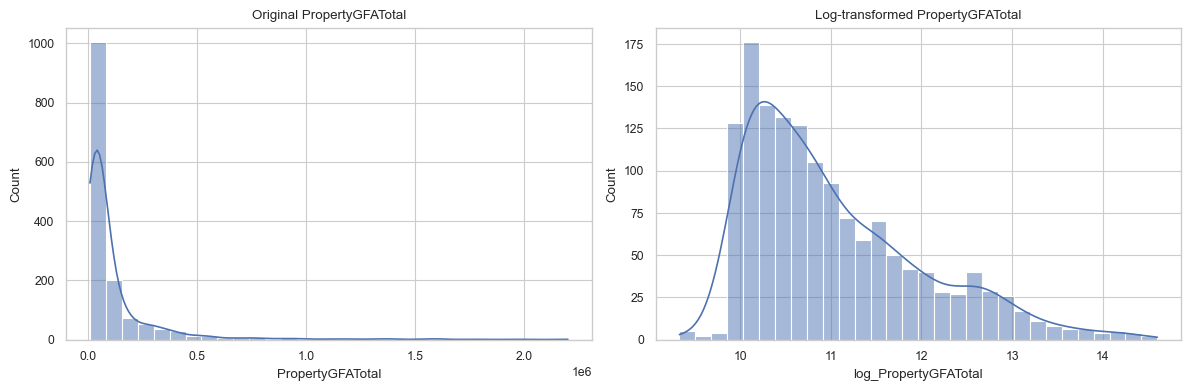

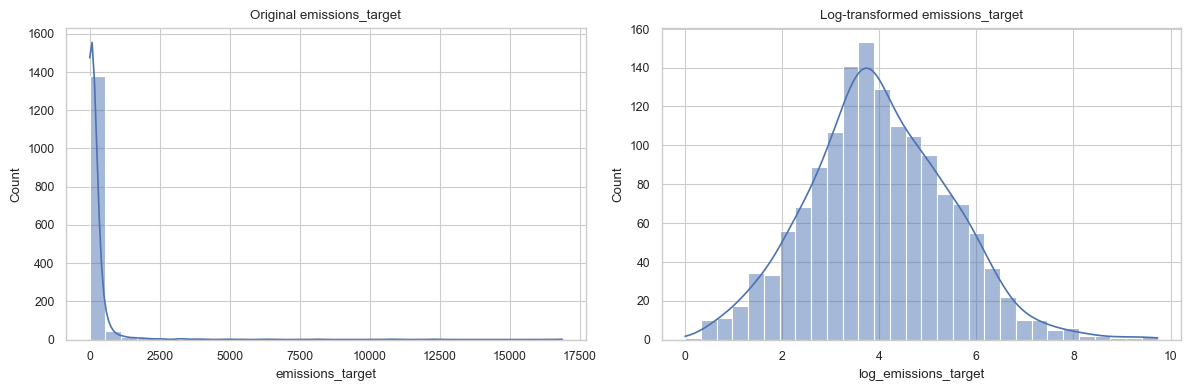

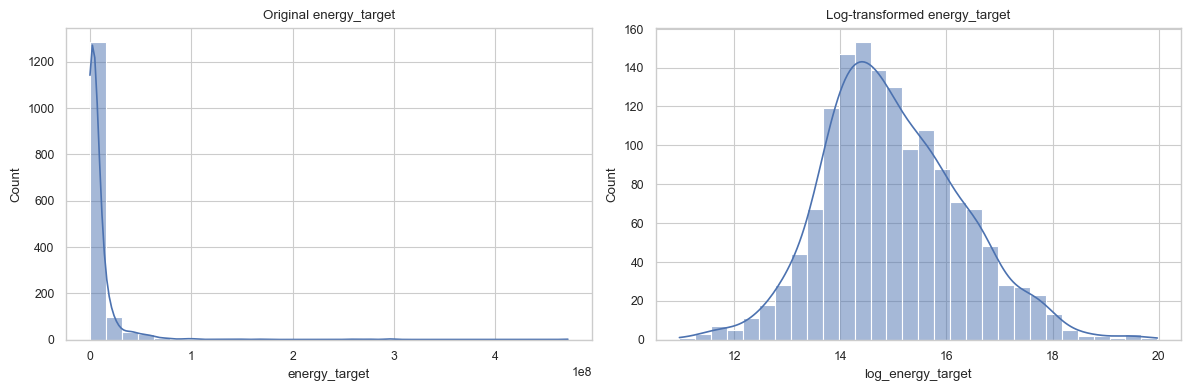

In [36]:
df_out = df_num.copy()

selected_columns = ['PropertyGFATotal', 'emissions_target', 'energy_target']

# Log transform
for col in selected_columns:
    df_out["log_" + col] = np.log1p(df_out[col])

# Calculate z-scores for the log-transformed energy_target and remove > 3
df_out['zscore_log_energy_target'] = zscore(df_out['log_energy_target'])
df_filtered = df_out[abs(df_out['zscore_log_energy_target']) <= 3].copy()

df_filtered.drop(columns=['zscore_log_energy_target'], inplace=True)

# Plot
for col in selected_columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df_filtered[col], kde=True, bins=30, ax=axes[0])
    axes[0].set_title(f'Original {col}')
    sns.histplot(df_filtered[f'log_{col}'], kde=True, bins=30, ax=axes[1])
    axes[1].set_title(f'Log-transformed {col}')
    plt.tight_layout()
    plt.savefig(f"./results/figures/log_transformation_{col}.png")
    plt.show()

In [37]:
# Skewness before and after log transformation
selected_columns = ['PropertyGFATotal', 'log_PropertyGFATotal', 
                    'emissions_target', 'log_emissions_target',
                    'energy_target', 'log_energy_target']

print(df_filtered[selected_columns].skew())

PropertyGFATotal        4.93243
log_PropertyGFATotal    1.05107
emissions_target       14.38232
log_emissions_target    0.23918
energy_target          10.77254
log_energy_target       0.35434
dtype: float64


### 6.2. Create New Features

To improve model performance and better represent building characteristics, I created several domain-informed features:

1. **Parking Proportion**

This feature captures the proportion of a building's gross floor area that is used for parking. Parking structures typically consume less energy than active-use areas, so this helps differentiate energy usage patterns between buildings with high and low parking allocations.

In [41]:
df_fea = df_filtered.copy()
df_fea['ParkingProportion'] = df_fea['PropertyGFAParking'] / df_fea['PropertyGFATotal']
df_fea['ParkingProportion'] = df_fea['ParkingProportion'].fillna(0)

2. **Energy Source Proportions**

These features represent the proportion of site energy sourced from electricity, natural gas, and steam respectively. They help the model understand not just how much energy a building consumes, but how that energy is supplied—important since different sources have different emissions profiles.

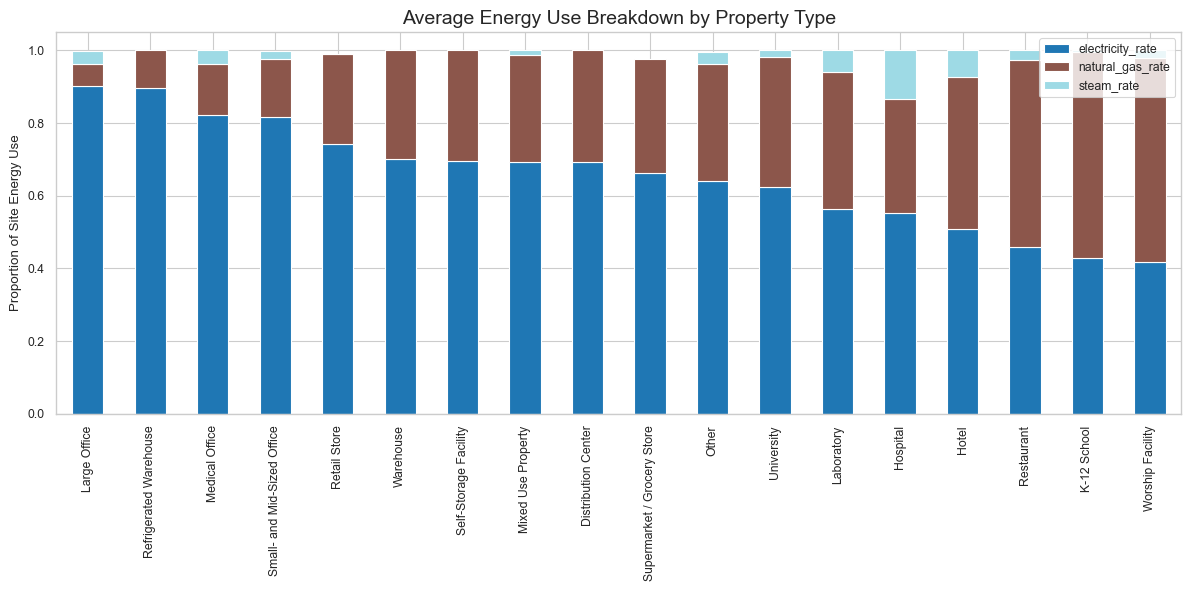

In [43]:
df_fea['electricity_rate'] = df_fea['Electricity(kBtu)'] / df_fea['SiteEnergyUse(kBtu)']
df_fea['natural_gas_rate'] = df_fea['NaturalGas(kBtu)'] / df_fea['SiteEnergyUse(kBtu)']
df_fea['steam_rate'] = df_fea['SteamUse(kBtu)'] / df_fea['SiteEnergyUse(kBtu)']

# Plot
energy_cols = ['electricity_rate', 'natural_gas_rate', 'steam_rate']
df_grouped = df_fea.groupby('PrimaryPropertyType')[energy_cols].mean().sort_values(by='electricity_rate', ascending=False)
df_grouped.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title('Average Energy Use Breakdown by Property Type', fontsize=14)
plt.ylabel('Proportion of Site Energy Use')
plt.xlabel('')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f"./results/figures/Average_Energy_Use_Breakdown_by_Property_Type.png")
plt.show()

3. **Use Counts**

This feature counts the number of different use types assigned to a building. Mixed-use buildings may have more complex consumption patterns than single-use ones, and this count provides a signal of that complexity.

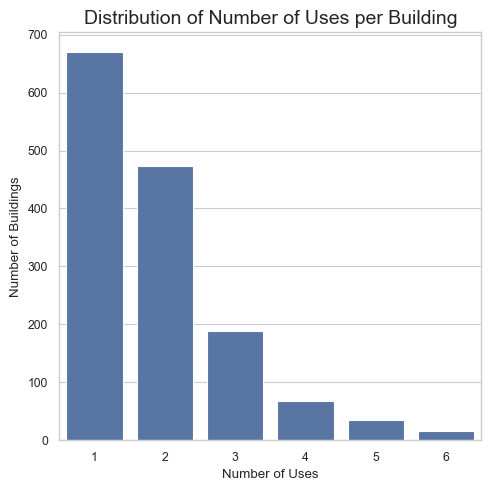

In [45]:
df_fea['use_counts'] = df_fea['ListOfAllPropertyUseTypes'].str.count(',') + 1

# Plot
df_visualise = df_fea[df_fea['use_counts'] < 7].copy()
plt.figure(figsize=(5, 5))
sns.countplot(x='use_counts', data=df_visualise, order=sorted(df_visualise['use_counts'].unique()))
plt.title('Distribution of Number of Uses per Building', fontsize=14)
plt.xlabel('Number of Uses')
plt.ylabel('Number of Buildings')
plt.tight_layout()
plt.savefig(f"./results/figures/Distribution_of_Number_of_Uses_per_Building.png")
plt.show()

4. **Property clusters**

Some buildings in the dataset have multiple property use types (e.g., office + retail). Instead of creating hundreds of binary variables, I created property use clusters to group similar building types based on their typical energy and emissions behavior.

* Each building can list up to three use types. I computed the area each use type occupies relative to the total reported area, to get largest_rate, second_rate, and third_rate.
* I grouped all use types into 5 clusters using KMeans, based on their median energy and emissions intensities. This helps simplify the model by identifying patterns in how different types of buildings perform.
* Each property use type was assigned a cluster number. This was done for all three use types per building.
* For each cluster (e.g. prop_cluster_0), I created a new feature representing how much of the building belongs to that cluster, weighted by area. This way, the model gets a numerical representation of the building's composition using fewer, more meaningful variables.

In [47]:
# Ratio of use largest, second, third PropertyUseTypeGFA
df_fea['all_PropertyUseTypeGFA'] = df_fea['LargestPropertyUseTypeGFA'] + df_fea['SecondLargestPropertyUseTypeGFA'] + df_fea['ThirdLargestPropertyUseTypeGFA']

df_fea['largest_rate'] = df_fea['LargestPropertyUseTypeGFA'] / df_fea['all_PropertyUseTypeGFA']
df_fea['second_rate'] = df_fea['SecondLargestPropertyUseTypeGFA'] / df_fea['all_PropertyUseTypeGFA']
df_fea['third_rate'] = df_fea['ThirdLargestPropertyUseTypeGFA'] / df_fea['all_PropertyUseTypeGFA']

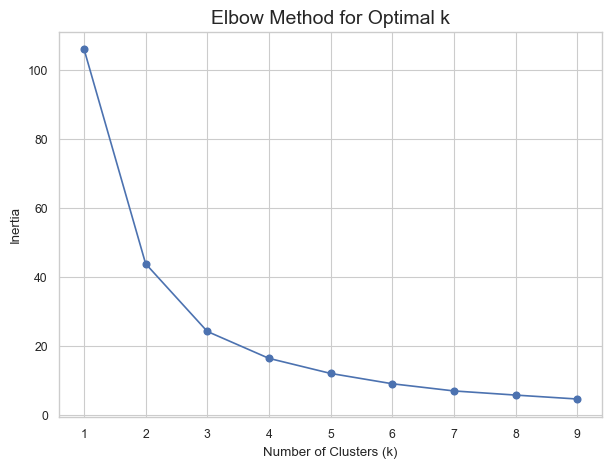

In [48]:
# Number of LargestPropertyUseType clusters
aggregated_stats = df_fea.groupby('LargestPropertyUseType').agg({
    'log_emissions_target': ['median'],
    'log_energy_target': ['median']
})

aggregated_stats.columns = ['log_emissions_median', 'log_energy_median']
aggregated_stats = aggregated_stats.reset_index()

features = ['log_emissions_median', 'log_energy_median']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(aggregated_stats[features])

inertias = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow
plt.figure(figsize=(7,5))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.xticks(k_range)
plt.grid(True)
plt.savefig(f"./results/figures/elbow_method_for_optimal_K.png")
plt.show()

In [49]:
# Silohette analysis
range_n_clusters = [2, 3, 4, 5, 6]
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is: {silhouette_avg:.3f}")

For n_clusters = 2, the average silhouette score is: 0.522
For n_clusters = 3, the average silhouette score is: 0.500
For n_clusters = 4, the average silhouette score is: 0.453
For n_clusters = 5, the average silhouette score is: 0.453
For n_clusters = 6, the average silhouette score is: 0.413


In [50]:
# Map clusters to df
kmeans_optimal = KMeans(n_clusters=5, random_state=42, n_init=10)
aggregated_stats['Cluster'] = kmeans_optimal.fit_predict(X_scaled)
print(aggregated_stats[['LargestPropertyUseType', 'Cluster']].sort_values(by='Cluster'))

cluster_mapping = dict(zip(aggregated_stats['LargestPropertyUseType'], aggregated_stats['Cluster']))

df_fea['LargestPropertyUseType_cluster'] = df_fea['LargestPropertyUseType'].map(cluster_mapping).fillna(-1).astype(int)
df_fea['SecondLargestPropertyUseType_cluster'] = df_fea['SecondLargestPropertyUseType'].map(cluster_mapping).fillna(-1).astype(int)
df_fea['ThirdLargestPropertyUseType_cluster'] = df_fea['ThirdLargestPropertyUseType'].map(cluster_mapping).fillna(-1).astype(int)

clusters = sorted(df_fea['LargestPropertyUseType_cluster'].unique())

for cluster in clusters:
    df_fea[f'prop_cluster_{cluster}'] = (
          (df_fea['LargestPropertyUseType_cluster'] == cluster).astype(float) * df_fea['largest_rate'] +
          (df_fea['SecondLargestPropertyUseType_cluster'] == cluster).astype(float) * df_fea['second_rate'] +
          (df_fea['ThirdLargestPropertyUseType_cluster'] == cluster).astype(float) * df_fea['third_rate']
    )

cols = [f'prop_cluster_{c}' for c in clusters]

                                  LargestPropertyUseType  Cluster
9                                         Fitness Center        0
34                              Other/Specialty Hospital        0
38                                        Police Station        0
50                   Urgent Care/Clinic/Other Outpatient        0
31                                Other - Restaurant/Bar        0
21                                                Museum        0
28                                          Other - Mall        0
49                             Supermarket/Grocery Store        0
48                                            Strip Mall        0
35                                               Parking        0
51                            Wholesale Club/Supercenter        0
44                                            Restaurant        0
13                                                 Hotel        0
22                            Non-Refrigerated Warehouse        1
52        

### 6.3. Encode Categorical Vairables

In [52]:
selected_columns = [
    # Categorical features
    'YearBuilt',
    'Neighborhood',
    'PrimaryPropertyType',

    # Numeric features
    'ParkingProportion',
    'electricity_rate',
    'natural_gas_rate',
    'steam_rate',
    'NumberofFloors',
    'log_PropertyGFATotal',
    'use_counts',
    'prop_cluster_0',
    'prop_cluster_1',
    'prop_cluster_2',
    'prop_cluster_3',
    'prop_cluster_4',
    'ENERGYSTARScore',

    # Targets
    'log_energy_target',
    'log_emissions_target',
]

df_selected = df_fea[selected_columns]

In [53]:
# Encode the categorical variable
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(df_selected[['PrimaryPropertyType']])
encoded_feature_names = encoder.get_feature_names_out(['PrimaryPropertyType'])

# Create a DataFrame for the encoded features
df_encoded = pd.DataFrame(encoded, columns=encoded_feature_names, index=df_selected.index)
df_selected = df_selected.drop(columns=['PrimaryPropertyType'])
df_selected = df_selected.join(df_encoded)

In [54]:
# Encode the categorical variable
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(df_selected[['Neighborhood']])
encoded_feature_names = encoder.get_feature_names_out(['Neighborhood'])

# Create a DataFrame for the encoded features
df_encoded = pd.DataFrame(encoded, columns=encoded_feature_names, index=df_selected.index)
df_selected = df_selected.drop(columns=['Neighborhood'])
df_selected = df_selected.join(df_encoded)

## 7. Export baseline dataset

In [56]:
df_selected.to_csv('./data/processed/feature_engineering_1_database.csv', index=False)

df_selected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1457 entries, 0 to 3375
Data columns (total 47 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   YearBuilt                                        1457 non-null   int64  
 1   ParkingProportion                                1457 non-null   float64
 2   electricity_rate                                 1457 non-null   float64
 3   natural_gas_rate                                 1457 non-null   float64
 4   steam_rate                                       1457 non-null   float64
 5   NumberofFloors                                   1457 non-null   int64  
 6   log_PropertyGFATotal                             1457 non-null   float64
 7   use_counts                                       1457 non-null   int64  
 8   prop_cluster_0                                   1457 non-null   float64
 9   prop_cluster_1                     